In [1]:
import csv
import gzip
import re

In [2]:
import matplotlib.pyplot as plt

In [3]:
from pybedtools import BedTool

In [4]:
from collections import defaultdict
from itertools import batched

In [5]:
tran2func = dict()
exon2tran = dict()

In [6]:
meta_exon2make_up = dict()

In [7]:
gene_bed = str()
exon_bed = str()

In [8]:
candidates = {
    'FE_FE': set(),
    'FE_NE': set()
}

In [9]:
with gzip.open("../data/ref/homo_sapiens/annot/Homo_sapiens.GRCh38.112.gtf.gz", 'rt') as f:
    for row in f:
        if row.startswith("#"):
            continue

        row = row.strip("\n").split("\t")
        chrom, _, feat, beg, end, _, strand, _, attr = row

        if feat in ["transcript", "exon", "CDS", "five_prime_utr", "three_prime_utr"]:
            gene = re.search(rf'(?<=gene_id ")\w+', attr).group(0)
            tran = re.search(rf'(?<=transcript_id ")\w+', attr).group(0)

            gene_func = re.search(rf'(?<=gene_biotype ")\w+', attr).group(0)
            tran_func = re.search(rf'(?<=transcript_biotype ")\w+', attr).group(0)

            if tran_func == "protein_coding" \
                    and feat in [ "CDS", "five_prime_utr", "three_prime_utr"]:
                gene_bed += (
                    f"{gene}\t"
                    f"{beg}\t"
                    f"{end}\t"
                    f"{chrom}\t"
                    f"{feat}\t"
                    f"{strand}\n"
                )

            if gene_func == "protein_coding":
                if feat == "transcript":
                    tran2func[tran] = tran_func

                if feat == "exon":
                    strand = int(strand == "+")
                    exon = f"{chrom}:{beg}-{end}:{strand}"

                    exon2tran[exon] = tran

In [10]:
with open("../data/ref/homo_sapiens/annot/out/meta_exon.csv", 'r') as f:
    reader = csv.reader(f)
    next(reader)

    for row in reader:
        gene, gene_func, chrom, meta_beg, meta_end, strand, meta_type, make_up = row

        if gene_func != "protein_coding" or meta_type != "FE":
            continue

        exon_bed += (
            f"{gene}\t"
            f"{meta_beg}\t"
            f"{meta_end}\t"
            f"{chrom}\t"
            f".\t"
            f"{strand}\n"
        )

        strand = int(strand == "+")
        meta_exon = f"{chrom}:{meta_beg}-{meta_end}:{strand}"

        make_up_pos = re.findall(r'\d+', make_up)
        make_up = [
            f"{chrom}:{beg}-{end}:{strand}" for beg, end in batched(make_up_pos, n=2)]

        meta_exon2make_up[meta_exon] = make_up

In [11]:
with open("../data/homology/ss/out/origin.csv", 'r') as f:
    reader = csv.reader(f)
    next(reader)

    for row in reader:
        p, meta_exon, p, ss,  _, gain_ages, loss_ages, pos_group, neg_group, tree_size, _ = row

        if int(tree_size) < 3 or ";" in gain_ages:
            # `";" in gain_events` indicates more than one gain event, which
            # we've opted to exclude.
            continue

        exon_type, exon = meta_exon.split("=")
        if exon_type != "FE":
            continue

        if "homo_sapiens" in pos_group \
                and "mus_musculus" in neg_group:
            candidates['FE_NE'].add(exon)

In [12]:
with open("../data/homology/exons/hsap_mmus.csv", 'r') as f:
    reader = csv.reader(f)

    for row in reader:
        hsap_exon, hsap_type, mmus_exon, mmus_type = row

        if hsap_exon in candidates['FE_NE']:
            if mmus_type != "NE":
                candidates['FE_NE'].remove(hsap_exon)

            if mmus_type == "FE":
                candidates['FE_FE'].add(hsap_exon)

In [13]:
meta_exon_tran_type = {
    'FE_FE': defaultdict(lambda: 0),
    'FE_NE': defaultdict(lambda: 0)
}

In [14]:
for stat, candidate_set in candidates.items():
    for meta_exon in candidate_set:
        make_up = meta_exon2make_up[meta_exon]

        for exon in make_up:
            tran = exon2tran[exon]
            tran_func = tran2func[tran]

            meta_exon_tran_type[stat][tran_func] += 1

In [15]:
pie1_xs = {'FE_FE': list(), 'FE_NE': list()}
pie1_ys = {'FE_FE': list(), 'FE_NE': list()}

In [16]:
pie2_xs = {'FE_FE': list(), 'FE_NE': list()}
pie2_ys = {'FE_FE': list(), 'FE_NE': list()}

In [17]:
for stat in meta_exon_tran_type:
    t = sum(meta_exon_tran_type[stat].values())

    for tran_type in sorted(meta_exon_tran_type[stat]):
        N = meta_exon_tran_type[stat][tran_type]

        pie1_xs[stat].append(tran_type)
        pie1_ys[stat].append(N / t)

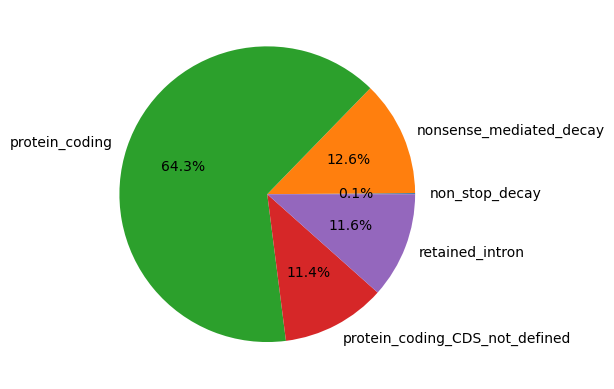

In [18]:
plt.pie(pie1_ys['FE_FE'], labels=pie1_xs['FE_FE'], autopct='%1.1f%%')
plt.savefig("figs/main4a_1.pdf")

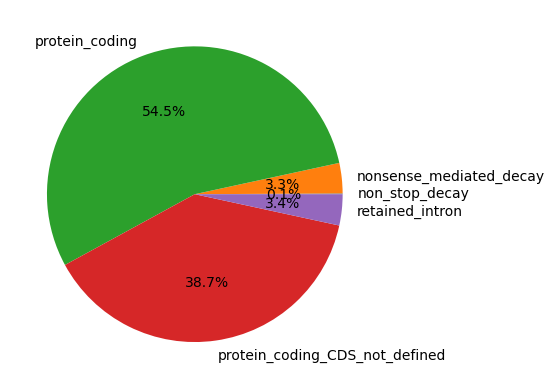

In [19]:
plt.pie(pie1_ys['FE_NE'], labels=pie1_xs['FE_NE'], autopct='%1.1f%%')
plt.savefig("figs/main4a_2.pdf")

In [20]:
exon_bed = BedTool(exon_bed, from_string=True)
gene_bed = BedTool(gene_bed, from_string=True)

In [21]:
exon_gene_bed = exon_bed.intersect(gene_bed, wo=True, s=True)

In [22]:
meta_exon_gene_pos = {
    'FE_FE': defaultdict(lambda: 0),
    'FE_NE': defaultdict(lambda: 0),
    'FE_AE': defaultdict(lambda: 0)
}

In [23]:
for row in exon_gene_bed:
    gene, beg, end, chrom, _, strand, *_, feat, _, _ = row

    strand = int(strand == "+")
    meta_exon = f"{chrom}:{beg}-{end}:{strand}"

    meta_exon_gene_pos['FE_AE'][feat] += 1
    stat = None

    if meta_exon in candidates['FE_FE']:
        stat = "FE_FE"

    if meta_exon in candidates['FE_NE']:
        stat = "FE_NE"

    if stat is None:
        continue

    meta_exon_gene_pos[stat][feat] += 1

In [24]:
for stat in meta_exon_gene_pos:
    t = sum(meta_exon_gene_pos[stat].values())

    for feat in sorted(meta_exon_gene_pos[stat]):
        N = meta_exon_gene_pos[stat][feat]

        if stat == "FE_AE":

            print(feat, N / t)
            continue

        pie2_xs[stat].append(feat)
        pie2_ys[stat].append(N / t)

CDS 0.30443964596730183
five_prime_utr 0.69484849203901
three_prime_utr 0.000711861993688157


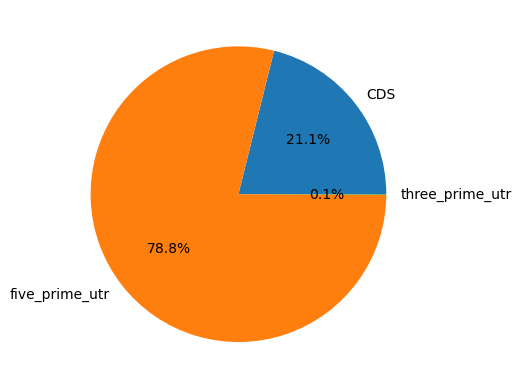

In [25]:
plt.pie(pie2_ys['FE_FE'], labels=pie2_xs['FE_FE'], autopct='%1.1f%%')
plt.savefig("figs/main4a_3.pdf")

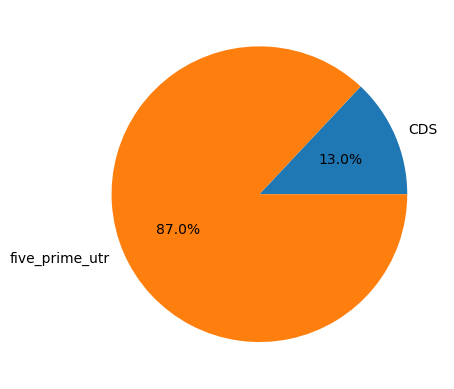

In [26]:
plt.pie(pie2_ys['FE_NE'], labels=pie2_xs['FE_NE'], autopct='%1.1f%%')
plt.savefig("figs/main4a_4.pdf")